In [1]:
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

nltk_sw = ['d', 'm', 'o', 's', 't', 'y', 'll', 're', 've', 'ma', "that'll", 'ain', "she's", "it's", "you're", "you've", "you'll", "youd", 'isn', "isn't", 'aren', "aren't", 'wasn', "wasn't", 'weren', "weren't", 'don', "don't", 'doesn', "doesn't", 'didn', "didn't", 'hasn', "hasn't", 'haven', "haven't", 'hadn', "hadn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", "shouldve", 'won', "won't", 'wouldn', "wouldn't", 'couldn', "couldn't", 'i', 'me', 'my', 'we', 'our', 'ours', 'you', 'your', 'yours', 'he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'they', 'them', 'their', 'theirs', 'himself', 'herself', 'itself', 'myself', 'yourself', 'yourselves', 'ourselves', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'had', 'has', 'have', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'again', 'further', 'then', 'once', 'can', 'will', 'just', 'should', 'now']
added_sw = ["he's", "he'd", "she'd", "he'll", "she'll", "you'll", "they'd", "could've", "would've", 'could', 'would', "i'm", 'im', "thatll", "shes", "youre", "youve", "youll", "youd", "isnt", "arent", "wasnt", "werent", "dont", "doesnt", "didnt", "hasnt", "havent", "hadnt", "mightnt", "mustnt", "neednt", "shant", "shouldnt", "shouldve", "wont", "wouldnt", "couldnt", 'a','b','c','e','f','g','h','i','j','k','l','n','p','q','r','u','v','w','x','z','lol']
stop_words = added_sw + nltk_sw
punc = ''',.;:?!'\"()[]{}<>|\\/@#^&*_~=+\\n\\t'''

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/richardph911/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/richardph911/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/richardph911/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/richardph911/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
import json
def load_data(file_path, chunk_size=100000, target_rows=288000):
    try:
        print(f"Attempting to load JSON file from: {file_path}")
        all_data = []
        total_rows = 0
        
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                try:
                    all_data.append(json.loads(line.strip()))
                    total_rows += 1
                except json.JSONDecodeError as e:
                    print(f"Skipping invalid JSON line {i + 1}: {e}")
                    continue
        
        print(f"Total rows loaded: {total_rows}")
        
        # Randomly sample to target_rows to approximate 5M non-zero values
        if total_rows > target_rows:
            all_data = random.sample(all_data, target_rows)
            print(f"Sampled down to {target_rows} rows to target 5M non-zero values")
        else:
            print("Dataset smaller than target, using all rows")
        
        df = pd.DataFrame(all_data)
        # print("JSON file loaded successfully. Columns:", df.columns.tolist())
        
        # print("\nFirst 100 rows of the DataFrame:")
        # print(df.head(100))
        
        if 'overall' not in df.columns:
            raise KeyError("'overall' column not found in the dataset")
        if 'reviewText' not in df.columns:
            raise KeyError("'reviewText' column not found in the dataset")
        if 'asin' not in df.columns:
            raise KeyError("'asin' column not found in the dataset")

        label_map = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1}
       
        df['label'] = df['overall'].map(label_map)
        
        if df['label'].isnull().any():
            raise ValueError("Some 'overall' values couldn't be mapped to labels. Invalid 'overall' values found.")

        df['title'] = df.get('reviewerName', '').astype(str)
        df['text'] = df['reviewText'].astype(str).fillna('')
        df['asin'] = df['asin'].astype(str)
        
        split_result = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
        if len(split_result) != 2:
            raise ValueError(f"train_test_split returned {len(split_result)} values, expected 2")
        train_df, test_df = split_result
        
        print("Dataset loaded successfully!")
        print(f"Training dataset shape: {train_df.shape}")
        print(f"Test dataset shape: {test_df.shape}")
        return train_df, test_df
    except Exception as e:
        print(f"Error in load_data: {str(e)}")
        return None, None

In [7]:
def preprocess_text(text,title=None):
    if not isinstance(text, str):
        text = str(text)
    if title is not None and isinstance(title, str):
        text = title + ' ' + text
    
    # Step 1: Handle contractions FIRST
    contraction_map = {
        "won't": "will not", "can't": "cannot", "n't": " not",
        "'re": " are", "'s": " is", "'d": " would", "'ll": " will",
        "'ve": " have", "'m": " am"
    }
    for contraction, expansion in contraction_map.items():
        text = text.replace(contraction, expansion)
    
    # Step 2: Remove URLs/numbers
    text = re.sub(r'https?://\S+|www\.\S+|\S+@\S+|\d+', '', text)
    # Keep letters, whitespace, hyphens, apostrophes
    text = re.sub(r"[^\w\s'-]", '', text)  
    
    # Step 4: Tokenize and clean
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    
    return ' '.join(tokens)


In [8]:
# Vectorize text using TF-IDF
def vectorize_text(train_text, test_text):
    try:
        print("Vectorizing text...")
        vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words=None)
        X_train = vectorizer.fit_transform(train_text)
        X_test = vectorizer.transform(test_text)
        total_non_zeros = X_train.nnz + X_test.nnz
        print(f"Total non-zero values in TF-IDF matrices: {total_non_zeros}")
        return X_train, X_test, vectorizer
    except Exception as e:
        print(f"Error in vectorize_text: {e}")
        return None, None, None

###Predict review

In [9]:
def predict_review(review, title, model, vectorizer):
    review = str(review) if review is not None else ''
    processed_text = preprocess_text(review, title=title)
    X_new = vectorizer.transform([processed_text])
    prediction = model.predict(X_new)[0]
    
    # Get confidence score
    confidence = None
    if hasattr(model, "predict_proba"):
        confidence = model.predict_proba(X_new)[0][1] if prediction == 1 else model.predict_proba(X_new)[0][0]
    
    sentiment = "Good (Positive)" if prediction == 1 else "Bad (Negative)"
    result = f"Predicted result: {sentiment}"
    if confidence is not None:
        result += f"\nConfidence Score: {confidence:.4f}"
    
    return result, prediction, confidence

Attempting to load JSON file from: /Users/richardph911/Desktop/Office_Products.json
Total rows loaded: 5581313
Sampled down to 288000 rows to target 5M non-zero values
Dataset loaded successfully!
Training dataset shape: (230400, 15)
Test dataset shape: (57600, 15)
Vectorizing text...
Total non-zero values in TF-IDF matrices: 5131002

Training Logistic Regression...
Logistic Regression Test Performance:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78     12441
           1       0.93      0.96      0.94     45159

    accuracy                           0.91     57600
   macro avg       0.89      0.84      0.86     57600
weighted avg       0.91      0.91      0.91     57600


Training Naive Bayes...
Naive Bayes Test Performance:
              precision    recall  f1-score   support

           0       0.84      0.57      0.68     12441
           1       0.89      0.97      0.93     45159

    accuracy                           0.88    

/var/folders/dx/dw4w48cs54j90_49_44ls9tw0000gn/T/ipykernel_2396/3197251414.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=model_names, y=accuracies, palette='viridis')



Product ASIN: B00QB3F4Y2
Positive Reviews: 0
Negative Reviews: 1
Best Model Accuracy: 0.9106
Review Confidence Scores: 0.8641
--------------------------------------------------

Product ASIN: B002C2UV0I
Positive Reviews: 4
Negative Reviews: 0
Best Model Accuracy: 0.9106
Review Confidence Scores: 0.9882, 0.9938, 0.9107, 0.9388
--------------------------------------------------

Product ASIN: B001C5Y9SG
Positive Reviews: 1
Negative Reviews: 0
Best Model Accuracy: 0.9106
Review Confidence Scores: 0.9816
--------------------------------------------------

Product ASIN: B0145X8GYY
Positive Reviews: 1
Negative Reviews: 0
Best Model Accuracy: 0.9106
Review Confidence Scores: 0.9881
--------------------------------------------------

Product ASIN: B00E3K547M
Positive Reviews: 13
Negative Reviews: 0
Best Model Accuracy: 0.9106
Review Confidence Scores: 0.9734, 0.7720, 0.9788, 0.9928, 0.9977, 0.6915, 0.9925, 0.6996, 0.7641, 0.9666, 0.9829, 0.9987, 0.8227
----------------------------------------

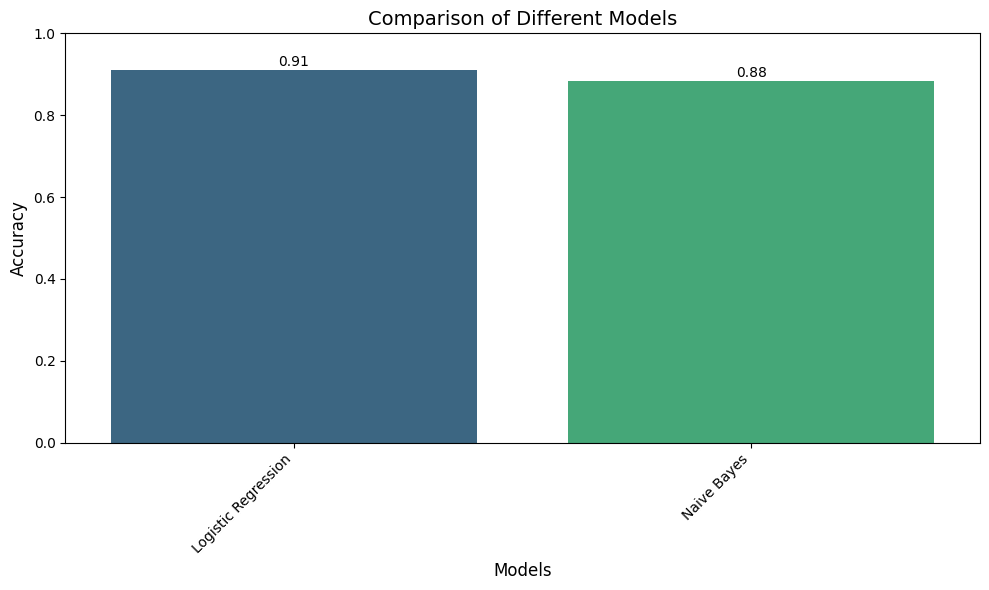

In [10]:
if __name__ == "__main__":
    json_path = '/Users/richardph911/Desktop/Office_Products.json'
    train_df, test_df = load_data(json_path)
    if train_df is not None and test_df is not None:
        train_df['reviews'] = train_df['title'].astype(str).fillna('') + ' ' + train_df['text'].astype(str).fillna('')
        test_df['reviews'] = test_df['title'].astype(str).fillna('') + ' ' + test_df['text'].astype(str).fillna('')
        train_df['text'] = train_df['reviews'].apply(preprocess_text)
        test_df['text'] = test_df['reviews'].apply(preprocess_text)
        train_df = train_df.drop(columns=['reviews'])
        test_df = test_df.drop(columns=['reviews'])
        # Vectorize vector
        X_train_full, X_test, vectorizer = vectorize_text(train_df['text'], test_df['text'])
        y_train_full = train_df['label'].values
        y_test = test_df['label'].values
        
        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "Naive Bayes": MultinomialNB(),
            # "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
        }
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
        )
        accuracies = []
        model_names = list(models.keys())
        trained_models = {}

        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train, y_train)
            trained_models[name] = model
            y_test_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_test_pred)
            accuracies.append(accuracy)
            print(f"{name} Test Performance:")
            print(classification_report(y_test, y_test_pred))

        best_model_name = model_names[np.argmax(accuracies)]
        best_model = trained_models[best_model_name]
        best_accuracy = max(accuracies)

        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=model_names, y=accuracies, palette='viridis')
        plt.xlabel('Models', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Comparison of Different Models', fontsize=14)
        plt.ylim(0, 1)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.2f}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black',
                        xytext=(0, 6), textcoords='offset points')
        plt.tight_layout()
        plt.savefig('model_comparison.png')

        from collections import defaultdict
        grouped_reviews = defaultdict(lambda: {"positive": [], "negative": [], "confidence_scores": []})

        reviews_to_predict = test_df.to_dict('records')
        for review_data in reviews_to_predict:
            try:
                asin = review_data["asin"]
                title = review_data["title"]
                text = review_data["text"]
                result, prediction, confidence = predict_review(text, title, best_model, vectorizer)
                sentiment = "positive" if prediction == 1 else "negative"
                review_info = {
                    "title": title,
                    "text": text,
                    "result": result,
                    "confidence": confidence
                }
                grouped_reviews[asin][sentiment].append(review_info)
                grouped_reviews[asin]["confidence_scores"].append(confidence)
            except Exception as e:
                print(f"Error processing review for ASIN {asin}: {e}")

        for asin, data in grouped_reviews.items():
            print(f"\nProduct ASIN: {asin}")
            positive_count = len(data["positive"])
            negative_count = len(data["negative"])
            print(f"Positive Reviews: {positive_count}")
            print(f"Negative Reviews: {negative_count}")
            print(f"Best Model Accuracy: {best_accuracy:.4f}")
            confidence_scores = [f"{score:.4f}" for score in data["confidence_scores"]]
            print(f"Review Confidence Scores: {', '.join(confidence_scores)}")
            print("-" * 50)
    else:
        print("Failed to load data")

In [13]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime

# Assuming you have these defined:
# model = your trained model
# vectorizer = your trained TfidfVectorizer
# accuracy = your model's accuracy

# Create a package with everything needed
model_package = {
    'model': best_model,
    'vectorizer': vectorizer,
    'metadata': {
        'created_at': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'classes': ['negative', 'positive']  # Update with your classes
    }
}

# Save to single file
with open('best_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)